In [1]:
using LinearAlgebra
using Plots
import JSON
# using Quaternions
using StaticArrays, Rotations
using Distributed
using StaticArrays, BenchmarkTools
using Base.Threads
using CUDAnative
using CuArrays,CUDAdrv 
using Test
import Base: +, * , -, ^

## Todo
- create struct for material and get for each edge its properties
- implement getTimestep (done)
- implement on single voxel (done)
- get reat E and L (done)
- compare to Frame3dd

In [2]:
struct Vector3
    x::Float64
    y::Float64
    z::Float64
    function Vector3()
        x=0.0
        y=0.0
        z=0.0
        new(x,y,z)
    end
    function Vector3(x,y,z)
       new(x,y,z)
    end
end
struct Quaternion
    x::Float64
    y::Float64
    z::Float64
    w::Float64
    function Quaternion()
        x=0.0
        y=0.0
        z=0.0
        w=1.0
        new(x,y,z,w)
    end
    function Quaternion(x,y,z,w)
        new(x,y,z,w)
    end
end
struct RotationMatrix
    te1::Float64
    te2::Float64
    te3::Float64
    te4::Float64
    te5::Float64
    te6::Float64
    te7::Float64
    te8::Float64
    te9::Float64
    te10::Float64
    te11::Float64
    te12::Float64
    te13::Float64
    te14::Float64
    te15::Float64
    te16::Float64
    function RotationMatrix()
        te1 =0.0
        te2 =0.0
        te3 =0.0
        te4 =0.0
        te5 =0.0
        te6 =0.0
        te7 =0.0
        te8 =0.0
        te9 =0.0
        te10=0.0
        te11=0.0
        te12=0.0
        te13=0.0
        te14=0.0
        te15=0.0
        te16=0.0
        new(te1,te2,te3,te4,te5,te6,te7,te8,te9,te10,te11,te12,te13,te14,te15,te16)
    end
    function RotationMatrix(te1,te2,te3,te4,te5,te6,te7,te8,te9,te10,te11,te12,te13,te14,te15,te16)
        new(te1,te2,te3,te4,te5,te6,te7,te8,te9,te10,te11,te12,te13,te14,te15,te16)
    end
end

+(f::Vector3, g::Vector3)=Vector3(f.x+g.x , f.y+g.y,f.z+g.z )
-(f::Vector3, g::Vector3)=Vector3(f.x-g.x , f.y-g.y,f.z-g.z )
*(f::Vector3, g::Vector3)=Vector3(f.x*g.x , f.y*g.y,f.z*g.z )

+(f::Vector3, g::Number)=Vector3(f.x+g , f.y+g,f.z+g )
-(f::Vector3, g::Number)=Vector3(f.x-g , f.y-g,f.z-g )
*(f::Vector3, g::Number)=Vector3(f.x*g , f.y*g,f.z*g )

+(g::Vector3, f::Number)=Vector3(f.x+g , f.y+g,f.z+g )
-(g::Vector3, f::Number)=Vector3(g-f.x , g-f.y,g-f.z )
*(g::Vector3, f::Number)=Vector3(f.x*g , f.y*g,f.z*g )

addX(f::Vector3, g::Number)=Vector3(f.x+g , f.y,f.z)
addY(f::Vector3, g::Number)=Vector3(f.x , f.y+g,f.z )
addZ(f::Vector3, g::Number)=Vector3(f.x , f.y,f.z+g )

function normalizeVector3(f::Vector3)
    leng=sqrt((f.x * f.x) + (f.y * f.y) + (f.z * f.z))
    return Vector3(f.x/leng,f.y/leng,f.z/leng)
    
end
function normalizeQuaternion(f::Quaternion)
    l = sqrt((f.x * f.x) + (f.y * f.y) + (f.z * f.z)+ (f.w * f.w))
    if l === 0 
        qx = 0
        qy = 0
        qz = 0
        qw = 1
    else 
        l = 1 / l
        qx = f.x * l
        qy = f.y * l
        qz = f.z * l
        qw = f.w * l
    end
    return Quaternion(qx,qy,qz,qw)
end

function normalizeQuaternion1!(fx::Float64,fy::Float64,fz::Float64,fw::Float64)
    l = sqrt((fx * fx) + (fy * fy) + (fz * fz)+ (fw * fw))
    if l === 0 
        qx = 0.0
        qy = 0.0
        qz = 0.0
        qw = 1.0
    else 
        l = 1.0 / l
        qx = fx * l
        qy = fy * l
        qz = fz * l
        qw = fw * l
    end
    return qx,qy,qz,qw
end


function dotVector3(f::Vector3, g::Vector3)
    return (f.x * g.x) + (f.y * g.y) + (f.z * g.z)
end

function Base.show(io::IO, v::Vector3)
    print(io, "x:$(v.x), y:$(v.y), z:$(v.z)")
end

function Base.show(io::IO, v::Quaternion)
    print(io, "x:$(v.x), y:$(v.y), z:$(v.z), w:$(v.z)")
end

Base.Broadcast.broadcastable(q::Vector3) = Ref(q)

In [3]:
function simulateParallel(numTimeSteps,dt)
    # initialize(setup)
    
    for i in 1:numTimeSteps
        #println("Timestep:",i)
        doTimeStep(dt,i)
    end
end

function simulateParallel(metavoxel,numTimeSteps,dt)
    # initialize(setup)
    
    for i in 1:numTimeSteps
        #println("Timestep:",i)
        doTimeStep(metavoxel,dt,i)
    end
end

simulateParallel (generic function with 2 methods)

In [4]:
function initialize(setup)
    nodes      = setup["nodes"]
    edges      = setup["edges"]

    i=1
    # pre-calculate current position
    for node in nodes
        # element=parse(Int,node["id"][2:end])
        N_position[i]=Vector3(node["position"]["x"]/100.0,node["position"]["y"]/100.0,node["position"]["z"]/100.0)
        N_restrained[i]=node["restrained_degrees_of_freedom"][1] ## todo later consider other degrees of freedom
        N_displacement[i]=Vector3(node["displacement"]["x"],node["displacement"]["y"],node["displacement"]["z"])
        N_angle[i]=Vector3(node["angle"]["x"],node["angle"]["y"],node["angle"]["z"])
        N_force[i]=Vector3(node["force"]["x"]/1,node["force"]["y"]/1,node["force"]["z"]/1)
        N_currPosition[i]=Vector3(node["position"]["x"]/100.0,node["position"]["y"]/100.0,node["position"]["z"]/100.0)

        # for dynamic simulations
        # append!(N_posTimeSteps,[[]])
        # append!(N_angTimeSteps,[[]])

        i=i+1
    end 

    i=1
    # pre-calculate the axis
    for edge in edges
        # element=parse(Int,edge["id"][2:end])

        # find the nodes that the lements connects
        fromNode = nodes[edge["source"]+1]
        toNode = nodes[edge["target"]+1]


        node1 = [fromNode["position"]["x"]/100.0 fromNode["position"]["y"]/100.0 fromNode["position"]["z"]/100.0]
        node2 = [toNode["position"]["x"]/100.0 toNode["position"]["y"]/100.0 toNode["position"]["z"]/100.0]

        length=norm(node2-node1)
        axis=normalize(collect(Iterators.flatten(node2-node1)))

        E_source[i]=edge["source"]+1
        E_target[i]=edge["target"]+1
        E_area[i]=edge["area"]
        E_density[i]=edge["density"]
        E_stiffness[i]=edge["stiffness"]
        E_axis[i]=Vector3(axis[1],axis[2],axis[3])
        E_currentRestLength[i]=length #?????????? todo change
#         E_currentRestLength[i]=75/sqrt(2)

        N_edgeID[E_source[i],N_currEdge[E_source[i]]]=i
        N_edgeFirst[E_source[i],N_currEdge[E_source[i]]]=true
        N_currEdge[E_source[i]]+=1

        N_edgeID[E_target[i],N_currEdge[E_target[i]]]=i
        N_edgeFirst[E_target[i],N_currEdge[E_target[i]]]=false
        N_currEdge[E_target[i]]+=1


        # for dynamic simulations
        # append!(E_stressTimeSteps,[[]])

        i=i+1
    end 
end

initialize (generic function with 1 method)

In [5]:
function doTimeStep(dt,currentTimeStep)
    # update forces: go through edges, get currentposition from nodes, calc pos2 and update stresses and interior forces of nodes
    run_updateEdges!(
        E_sourceGPU, 
        E_targetGPU,
        E_areaGPU,
        E_densityGPU,
        E_stiffnessGPU,
        E_stressGPU,
        E_axisGPU,
        E_currentRestLengthGPU,
        E_pos2GPU,
        E_angle1vGPU,
        E_angle2vGPU,
        E_angle1GPU,
        E_angle2GPU,
        E_intForce1GPU,
        E_intMoment1GPU,
        E_intForce2GPU,
        E_intMoment2GPU,
        E_dampGPU,
        N_currPositionGPU,
        N_orientGPU)
    
    # update forces: go through nodes and update interior force (according to int forces from edges), integrate and update currpos
    run_updateNodes!(dt,currentTimeStep,
        N_positionGPU, 
        N_restrainedGPU,
        N_displacementGPU,
        N_angleGPU,
        N_currPositionGPU,
        N_linMomGPU,
        N_angMomGPU,
        N_intForceGPU,
        N_intMomentGPU,
        N_forceGPU,
        N_momentGPU,
        N_orientGPU,
        N_edgeIDGPU, 
        N_edgeFirstGPU, 
        E_intForce1GPU,
        E_intMoment1GPU,
        E_intForce2GPU,
        E_intMoment2GPU)
    
end

function doTimeStep!(metavoxel,dt,currentTimeStep)
    # update forces: go through edges, get currentposition from nodes, calc pos2 and update stresses and interior forces of nodes
    run_updateEdges!(
        metavoxel["E_sourceGPU"], 
        metavoxel["E_targetGPU"],
        metavoxel["E_areaGPU"],
        metavoxel["E_densityGPU"],
        metavoxel["E_stiffnessGPU"],
        metavoxel["E_stressGPU"],
        metavoxel["E_axisGPU"],
        metavoxel["E_currentRestLengthGPU"],
        metavoxel["E_pos2GPU"],
        metavoxel["E_angle1vGPU"],
        metavoxel["E_angle2vGPU"],
        metavoxel["E_angle1GPU"],
        metavoxel["E_angle2GPU"],
        metavoxel["E_intForce1GPU"],
        metavoxel["E_intMoment1GPU"],
        metavoxel["E_intForce2GPU"],
        metavoxel["E_intMoment2GPU"],
        metavoxel["E_dampGPU"],
        metavoxel["N_currPositionGPU"],
        metavoxel["N_orientGPU"])
    
    # update forces: go through nodes and update interior force (according to int forces from edges), integrate and update currpos
    run_updateNodes!(dt,currentTimeStep,
        metavoxel["N_positionGPU"], 
        metavoxel["N_restrainedGPU"],
        metavoxel["N_displacementGPU"],
        metavoxel["N_angleGPU"],
        metavoxel["N_currPositionGPU"],
        metavoxel["N_linMomGPU"],
        metavoxel["N_angMomGPU"],
        metavoxel["N_intForceGPU"],
        metavoxel["N_intMomentGPU"],
        metavoxel["N_forceGPU"],
        metavoxel["N_momentGPU"],
        metavoxel["N_orientGPU"],
        metavoxel["N_edgeIDGPU"], 
        metavoxel["N_edgeFirstGPU"], 
        metavoxel["E_intForce1GPU"],
        metavoxel["E_intMoment1GPU"],
        metavoxel["E_intForce2GPU"],
        metavoxel["E_intMoment2GPU"])
    
end

doTimeStep! (generic function with 1 method)

In [6]:
function updateEdges!(E_source,E_target,E_area,E_density,E_stiffness,E_stress,E_axis,
        E_currentRestLength,E_pos2,E_angle1v,E_angle2v,
        E_angle1,E_angle2,E_intForce1,E_intMoment1,E_intForce2,E_intMoment2,E_damp,
        N_currPosition,N_orient)

    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = blockDim().x * gridDim().x
    ## @cuprintln("thread $index, block $stride")
    N=length(E_source)
    for i = index:stride:N
        
        @inbounds pVNeg=N_currPosition[E_source[i]]
        @inbounds pVPos=N_currPosition[E_target[i]]
        
        @inbounds oVNeg=N_orient[E_source[i]]
        @inbounds oVPos=N_orient[E_target[i]]
        
        @inbounds oldPos2=Vector3(E_pos2[i].x,E_pos2[i].y,E_pos2[i].z) #?copy?
        @inbounds oldAngle1v = Vector3(E_angle1v[i].x,E_angle1v[i].y,E_angle1v[i].z)
        @inbounds oldAngle2v = Vector3(E_angle2v[i].x,E_angle2v[i].y,E_angle2v[i].z)# remember the positions/angles from last timestep to calculate velocity
        
        
        @inbounds E_pos2[i],E_angle1v[i],E_angle2v[i],E_angle1[i],E_angle2[i],totalRot= orientLink!(E_currentRestLength[i],pVNeg,pVPos,oVNeg,oVPos,E_axis[i])
        
        @inbounds dPos2   = Vector3(0.5,0.5,0.5) * (E_pos2[i]-oldPos2)  #deltas for local damping. velocity at center is half the total velocity
        @inbounds dAngle1 = Vector3(0.5,0.5,0.5) *(E_angle1v[i]-oldAngle1v)
        @inbounds dAngle2 = Vector3(0.5,0.5,0.5) *(E_angle2v[i]-oldAngle2v)
        
        
        @inbounds strain=(E_pos2[i].x/E_currentRestLength[i])
        
        positiveEnd=true
        if axialStrain( positiveEnd,strain)>100.0
            diverged=true
            @cuprintln("DIVERGED!!!!!!!!!!")
            return 
        end
        
        @inbounds E = E_stiffness[i]
        
        
        
        @inbounds l   = E_currentRestLength[i]
        
        
        nu=0
#         L = 5.0 #?? change!!!!!!
        L=l
        a1 = E*L # EA/L : Units of N/m
        a2 = E * L*L*L / (12.0*(1+nu)) # GJ/L : Units of N-m
        b1 = E*L # 12EI/L^3 : Units of N/m
        b2 = E*L*L/2.0 # 6EI/L^2 : Units of N (or N-m/m: torque related to linear distance)
        b3 = E*L*L*L/6.0 # 2EI/L : Units of N-m
        
        nu=0.35
        W = 75
#         L = W/sqrt(2)
        l=L
        n_min = 1
        n_max = 7
        # Cross Section inputs, must be floats
        mass=125000 #before for voxel
        mass=1
        E = 2000e9  # MPa
        G = E * 1 / 3  # MPa
        h = 2.38/100.0  # mm
        b = 2.38/100.0 # mm
        rho = 7.85e-9 / 3  # kg/mm^3
        S = h * b
        Sy = (S * (6 + 12 * nu + 6 * nu^2)/ (7 + 12 * nu + 4 * nu^2))
        # For solid rectangular cross section (width=b, depth=d & ( b < d )):
        Q = 1 / 3 - 0.2244 / (min(h / b, b / h) + 0.1607)
        Jxx = Q * min(h * b^3, b * h^3)
        s=b
    
        MaxFreq2=E*s/mass
        dt= 1/(6.283185*sqrt(MaxFreq2))


        ##if voxels
        #nu=0
        #L=l
        #a1 = E*L # EA/L : Units of N/m
        #a2 = E * L*L*L / (12.0*(1+nu)) # GJ/L : Units of N-m
        #b1 = E*L # 12EI/L^3 : Units of N/m
        #b2 = E*L*L/2.0 # 6EI/L^2 : Units of N (or N-m/m: torque related to linear distance)
        #b3 = E*L*L*L/6.0 # 2EI/L : Units of N-m

        I= b*h^3/12
        J=b*h*(b*b+h*h)/12
        a1=E*b*h/L
        a2=G*J/L
        b1=12*E*I/(L^3)
        b2=6*E*I/(L^2)
        b3=2*E*I/(L)
        
        

        
        #inbounds currentTransverseArea=25.0 #?? change!!!!!! E_area[i]
        @inbounds currentTransverseArea= b*h
        @inbounds _stress=updateStrain(strain,E)
        
        #@inbounds currentTransverseArea= E_area[i]
        #@inbounds _stress=updateStrain(strain,E_stiffness[i])
        
        @inbounds E_stress[i]=_stress
        
        #@cuprintln("_stress $_stress")
        x=(_stress*currentTransverseArea)
        @inbounds y=(b1*E_pos2[i].y-b2*(E_angle1v[i].z + E_angle2v[i].z))
        @inbounds z=(b1*E_pos2[i].z + b2*(E_angle1v[i].y + E_angle2v[i].y))
        
        x=convert(Float64,x)
        y=convert(Float64,y)
        z=convert(Float64,z)
        
        # Use Curstress instead of -a1*Pos2.x to account for non-linear deformation 
        forceNeg = Vector3(x,y,z)
        
        forcePos = Vector3(-x,-y,-z)
        
        @inbounds x= (a2*(E_angle2v[i].x-E_angle1v[i].x))
        @inbounds y= (-b2*E_pos2[i].z-b3*(2.0*E_angle1v[i].y+E_angle2v[i].y))
        @inbounds z=(b2*E_pos2[i].y - b3*(2.0*E_angle1v[i].z + E_angle2v[i].z))  
        x=convert(Float64,x)
        y=convert(Float64,y)
        z=convert(Float64,z)
        momentNeg = Vector3(x,y,z)
        

        @inbounds x= (a2*(E_angle1v[i].x-E_angle2v[i].x))
        @inbounds y= (-b2*E_pos2[i].z- b3*(E_angle1v[i].y+2.0*E_angle2v[i].y))
        @inbounds z=(b2*E_pos2[i].y - b3*(E_angle1v[i].z + 2.0*E_angle2v[i].z))
        x=convert(Float64,x)
        y=convert(Float64,y)
        z=convert(Float64,z)
        momentPos = Vector3(x,y,z)
        
        
        ### damping
        @inbounds if E_damp[i] #first pass no damping
            sqA1=CUDAnative.sqrt(a1) 
            sqA2xIp=CUDAnative.sqrt(a2*L*L/6.0) 
            sqB1=CUDAnative.sqrt(b1) 
            sqB2xFMp=CUDAnative.sqrt(b2*L/2) 
            sqB3xIp=CUDAnative.sqrt(b3*L*L/6.0)
            
            dampingMultiplier=Vector3(28099.3,28099.3,28099.3) # 2*mat->_sqrtMass*mat->zetaInternal/previousDt;?? todo link to material
            
            zeta=1
            dampingM= 2*sqrt(mass)*zeta/dt
            dampingMultiplier=Vector3(dampingM,dampingM,dampingM)
            
            posCalc=Vector3(sqA1*dPos2.x, sqB1*dPos2.y - sqB2xFMp*(dAngle1.z+dAngle2.z),sqB1*dPos2.z + sqB2xFMp*(dAngle1.y+dAngle2.y))
            
            
            forceNeg =forceNeg + (dampingMultiplier*posCalc);
            forcePos =forcePos - (dampingMultiplier*posCalc);

            momentNeg -= Vector3(0.5,0.5,0.5)*dampingMultiplier*Vector3(-sqA2xIp*(dAngle2.x - dAngle1.x),
                                                                    sqB2xFMp*dPos2.z + sqB3xIp*(2*dAngle1.y + dAngle2.y),
                                                                    -sqB2xFMp*dPos2.y + sqB3xIp*(2*dAngle1.z + dAngle2.z));
            momentPos -= Vector3(0.5,0.5,0.5)*dampingMultiplier*Vector3(sqA2xIp*(dAngle2.x - dAngle1.x),
                                                                sqB2xFMp*dPos2.z + sqB3xIp*(dAngle1.y + 2*dAngle2.y),
                                                                -sqB2xFMp*dPos2.y + sqB3xIp*(dAngle1.z + 2*dAngle2.z));

        else
           @inbounds E_damp[i]=true 
        end

        smallAngle=true
        if !smallAngle # ?? check
            @inbounds forceNeg = RotateVec3DInv(E_angle1[i],forceNeg)
            @inbounds momentNeg = RotateVec3DInv(E_angle1[i],momentNeg)
        end
        
        @inbounds forcePos = RotateVec3DInv(E_angle2[i],forcePos)
        @inbounds momentPos = RotateVec3DInv(E_angle2[i],momentPos)

        @inbounds forceNeg =toAxisOriginalVector3(forceNeg,E_axis[i])
        @inbounds forcePos =toAxisOriginalVector3(forcePos,E_axis[i])

        @inbounds momentNeg=toAxisOriginalQuat(momentNeg,E_axis[i])# TODOO CHECKKKKKK
        @inbounds momentPos=toAxisOriginalQuat(momentPos,E_axis[i])


        @inbounds E_intForce1[i] =forceNeg
        @inbounds E_intForce2[i] =forcePos
        


        @inbounds x= momentNeg.x
        @inbounds y= momentNeg.y
        @inbounds z= momentNeg.z  
        x=convert(Float64,x)
        y=convert(Float64,y)
        z=convert(Float64,z)
        
        @inbounds E_intMoment1[i]=Vector3(x,y,z)

        @inbounds x= momentNeg.x
        @inbounds y= momentNeg.y
        @inbounds z= momentNeg.z
        x=convert(Float64,x)
        y=convert(Float64,y)
        z=convert(Float64,z)
        
        @inbounds E_intMoment2[i]=Vector3(x,y,z)
        
        #x=E_pos2[i].x*10000000000
        #y=E_pos2[i].y*10000000000
        #z=E_pos2[i].z*10000000000
        #@cuprintln("pos2 x $x, y $y, z $z ")
        ##x=E_intMoment2[i].x*10000000000
        #y=E_intMoment2[i].y*10000000000
        #z=E_intMoment2[i].z*10000000000
        #@cuprintln("E_intMoment2 x $x, y $y, z $z ")

        
        
    end
    return
end

function run_updateEdges!(E_source,E_target,E_area,E_density,E_stiffness,
        E_stress,E_axis,E_currentRestLength,E_pos2,E_angle1v,E_angle2v,
        E_angle1,E_angle2,E_intForce1,E_intMoment1,E_intForce2,E_intMoment2,
        E_damp,N_currPosition,N_orient)
    N=length(E_source)
    numblocks = ceil(Int, N/256)
    CuArrays.@sync begin
        @cuda threads=256 blocks=numblocks updateEdges!(E_source,E_target,E_area,E_density,
            E_stiffness,E_stress,E_axis,E_currentRestLength,E_pos2,E_angle1v,
            E_angle2v,E_angle1,E_angle2,E_intForce1,E_intMoment1,E_intForce2,
            E_intMoment2,E_damp,N_currPosition,N_orient)
    end
end

run_updateEdges! (generic function with 1 method)

In [7]:
function updateNodes!(dt,currentTimeStep,N_position, N_restrained,N_displacement,N_angle,N_currPosition,N_linMom,N_angMom,N_intForce,N_intMoment,N_force,N_moment,N_orient,N_edgeID,N_edgeFirst,E_intForce1,E_intMoment1,E_intForce2,E_intMoment2)

    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = blockDim().x * gridDim().x
    ## @cuprintln("thread $index, block $stride")
    N,M=size(N_edgeID)
    for i = index:stride:N
        @inbounds if N_restrained[i]
            return
        else
            for j in 1:M
                temp=N_edgeID[i,j]
                @inbounds if (N_edgeID[i,j]!=-1)
                    #@cuprintln("i $i, j $j, N_edgeID[i,j] $temp")
                    @inbounds N_intForce[i]=ifelse(N_edgeFirst[i,j], N_intForce[i]+E_intForce1[N_edgeID[i,j]], N_intForce[i]+E_intForce2[N_edgeID[i,j]] )
                    @inbounds N_intMoment[i]=ifelse(N_edgeFirst[i,j], N_intMoment[i]+E_intMoment1[N_edgeID[i,j]], N_intMoment[i]+E_intMoment2[N_edgeID[i,j]] )
                end
            end
            @inbounds curForce = force(N_intForce[i],N_orient[i],N_force[i],true,currentTimeStep)
            
            #@inbounds N_force[i]=Vector3(0,0,0) ##????
            
            @inbounds N_intForce[i]=Vector3(0,0,0)
        
            #x=curForce.x
            #y=curForce.y
            #z=curForce.z
            #@cuprintln("curForce x $x, y $y, z $z ")
            
            #x=N_linMom[i].x*10000000000
            #y=N_linMom[i].y*10000000000
            #z=N_linMom[i].z*10000000000
            #@cuprintln("N_linMom[i] x $x, y $y, z $z ")
            
            
            @inbounds N_linMom[i]=N_linMom[i]+curForce*Vector3(dt,dt,dt) #todo make sure right
            massInverse=8e-6 # todo ?? later change //8e-6
            mass=1
            massInverse=1.0/mass #
            @inbounds translate=N_linMom[i]*Vector3((dt*massInverse),(dt*massInverse),(dt*massInverse)) # ??massInverse
            
            #x=translate.x*10000000000
            #y=translate.y*10000000000
            #z=translate.z*10000000000
            #@cuprintln("translate x $x, y $y, z $z ")
            
            @inbounds N_currPosition[i]=N_currPosition[i]+translate
            @inbounds N_displacement[i]=N_displacement[i]+translate
            
            
            
            # Rotation
            @inbounds curMoment = moment(N_intMoment[i],N_orient[i],N_moment[i]) 
            
            
            
            @inbounds N_intMoment[i]=Vector3(0,0,0) # do i really need it?
            
            @inbounds N_angMom[i]=N_angMom[i]+curMoment*Vector3(dt,dt,dt)
            
            
            
            
            momentInertiaInverse=1.92e-6 # todo ?? later change 1/Inertia (1/(kg*m^2))
            
            
            @inbounds temp=FromRotationVector(N_angMom[i]*Vector3((dt*momentInertiaInverse),(dt*momentInertiaInverse),(dt*momentInertiaInverse)))
            
            
            #x=temp.x*10000000000
            #y=temp.y*10000000000
            #z=temp.z*10000000000
            #@cuprintln("temp x $x, y $y, z $z ")
            
            @inbounds N_orient[i]=multiplyQuaternions(temp,N_orient[i])
            
            #@inbounds x= N_orient[i].x*temp.x
            #@inbounds y= N_orient[i].y*temp.y
            #@inbounds z= N_orient[i].z*temp.z
            #@inbounds w= N_orient[i].w*temp.w
            #x=convert(Float64,x)
            #y=convert(Float64,y)
            #z=convert(Float64,z)
            #w=convert(Float64,w)
            
            #@inbounds N_orient[i]=Quaternion(x,y,z,w)
            
            #x=N_orient[i].x*10000000000
            #y=N_orient[i].y*10000000000
            #z=N_orient[i].z*10000000000
            #w=N_orient[i].w
            #@cuprintln("N_orient x $x, y $y, z $z, w $w ")
            
            
        end
    end
    return
end


function run_updateNodes!(dt,currentTimeStep,N_position, N_restrained,N_displacement, N_angle,N_currPosition,N_linMom,N_angMom,N_intForce,N_intMoment,N_force,N_moment,N_orient,N_edgeID,N_edgeFirst,E_intForce1,E_intMoment1,E_intForce2,E_intMoment2)
    N=length(N_intForce)
    numblocks = ceil(Int, N/256)
    CuArrays.@sync begin
        @cuda threads=256 blocks=numblocks updateNodes!(dt,currentTimeStep,N_position, N_restrained,N_displacement, N_angle,N_currPosition,N_linMom,N_angMom,N_intForce,N_intMoment,N_force,N_moment,N_orient,N_edgeID,N_edgeFirst,E_intForce1,E_intMoment1,E_intForce2,E_intMoment2)
    end
end

run_updateNodes! (generic function with 1 method)

In [8]:
function orientLink!(currentRestLength,pVNeg,pVPos,oVNeg,oVPos,axis)  # updates pos2, angle1, angle2, and smallAngle //Quat3D<double> /*double restLength*/
        
    pos2 = toAxisXVector3(pVPos-pVNeg,axis) # digit truncation happens here...
    angle1 = toAxisXQuat(oVNeg,axis)
    angle2 = toAxisXQuat(oVPos,axis)
    
    #x=pos2.x*10000000000
    #y=pos2.y*10000000000
    #z=pos2.z*10000000000
    #@cuprintln("pos2 x $x, y $y, z $z ")
    
    #x=angle1.x*10000000000
    #y=angle1.y*10000000000
    #z=angle1.z*10000000000
    #@cuprintln("angle1 x $x, y $y, z $z ")
    #x=oVNeg.x*10000000000
    #y=oVNeg.y*10000000000
    #z=oVNeg.z*10000000000
    #@cuprintln("oVNeg x $x, y $y, z $z ")
    
    
    
    totalRot = conjugate(angle1) #keep track of the total rotation of this bond (after toAxisX()) # Quat3D<double>
    pos2 = RotateVec3D(totalRot,pos2)
    
    #x=pos2.x*10000000000
    #y=pos2.y*10000000000
    #z=pos2.z*10000000000
    #@cuprintln("pos2 2 x $x, y $y, z $z ")
    
    
    #x=totalRot.x*10000000000
    #y=totalRot.y*10000000000
    #z=totalRot.z*10000000000
    #@cuprintln("totalRot x $x, y $y, z $z ")
    
    
#     x=pos2.x*10000000000
#     y=pos2.y*10000000000
#     z=pos2.z*10000000000
#     @cuprintln("pos2 x $x, y $y, z $z ")
    
    angle2 = Quaternion(angle2.x*totalRot.x,angle2.y*totalRot.y,angle2.z*totalRot.z,angle2.w*totalRot.w)
    angle1 = Quaternion(0.0,0.0,0.0,1.0)#new THREE.Quaternion() #zero for now...

    smallAngle=true #todo later remove
    
    
    if (smallAngle)	 #Align so Angle1 is all zeros
        #pos2[1] =pos2[1]- currentRestLength #only valid for small angles
        pos2=Vector3(pos2.x-currentRestLength,pos2.y,pos2.z)
    else  #Large angle. Align so that Pos2.y, Pos2.z are zero.
        # FromAngleToPosX(angle1,pos2) #get the angle to align Pos2 with the X axis
        # totalRot = angle1.clone().multiply(totalRot)  #update our total rotation to reflect this
        # angle2 = angle1.clone().multiply(  angle2) #rotate angle2
        # pos2 = new THREE.Vector3(pos2.length() - currentRestLength, 0, 0);
    end
    
    angle1v = ToRotationVector(angle1)
    angle2v = ToRotationVector(angle2)
    
    
    
    
#     pos2,angle1v,angle2v,angle1,angle2,
    return pos2,angle1v,angle2v,angle1,angle2,totalRot
end

orientLink! (generic function with 1 method)

In [9]:
function toAxisXVector3(pV::Vector3,axis::Vector3) #TODO CHANGE

    xaxis=Vector3(1.0,0.0,0.0)

    vector=normalizeVector3(axis)
    q=setFromUnitVectors(vector,xaxis)
    
    
 
#     rot=setFromRotationMatrix(quatToMatrix( q  ))
    
    
#     v= applyQuaternion1( pV ,setQuaternionFromEuler(rot) )
    v=applyQuaternion1( pV ,q )
    
    #d=15
    #vx=round(v.x, digits=d)
    #vy=round(v.y, digits=d)
    #vz=round(v.z, digits=d)
    
    
    return Vector3(v.x,v.y,v.z)
end

function toAxisOriginalVector3(pV::Vector3,axis::Vector3)
    
    xaxis=Vector3(1.0,0.0,0.0)

    vector=normalizeVector3(axis)

    q=setFromUnitVectors(xaxis,vector)
    

#     rot=setFromRotationMatrix(quatToMatrix( q  ))

#     v= applyQuaternion1( pV ,setQuaternionFromEuler(rot) )
    v=applyQuaternion1( pV ,q )
    
    #d=15
    #vx=round(v.x, digits=d)
    #vy=round(v.y, digits=d)
    #vz=round(v.z, digits=d)
    
    
    return Vector3(v.x,v.y,v.z)
end

function  toAxisXQuat(pQ::Quaternion,axis::Vector3)
    
    xaxis=Vector3(1.0,0.0,0.0)

    vector=normalizeVector3(axis)


    q=setFromUnitVectors(vector,xaxis)
        
    #d=17
    #qw=round(q[1], digits=d)
    #qx=round(q[2], digits=d)
    #qy=round(q[3], digits=d)
    #qz=round(q[4], digits=d)
    #

#     rot=setFromRotationMatrix(quatToMatrix( q  ))
    
    pV=Vector3(pQ.x,pQ.y,pQ.z)
    
#     v=applyQuaternion1( pV ,setQuaternionFromEuler(rot) )
    v=applyQuaternion1( pV ,q )
    
    #d=15
    #vx=round(v.x, digits=d)
    #vy=round(v.y, digits=d)
    #vz=round(v.z, digits=d)
    
    return Quaternion(v.x,v.y,v.z,1.0)
    
    # return [1.0 v[1] v[2] v[3]]
end

function toAxisOriginalQuat(pQ::Vector3,axis::Vector3)
    xaxis=Vector3(1.0,0.0,0.0)

    vector=normalizeVector3(axis)
    
    q=setFromUnitVectors(xaxis,vector)
    

#     rot=setFromRotationMatrix(quatToMatrix( q  ))
    
    pV=Vector3(pQ.x,pQ.y,pQ.z)
#     v=applyQuaternion1( pV ,setQuaternionFromEuler(rot) )
    v=applyQuaternion1( pV ,q )
    
    #d=15
    #vx=round(v.x, digits=d)
    #vy=round(v.y, digits=d)
    #vz=round(v.z, digits=d)
    
    return Quaternion(v.x,v.y,v.z,1.0)
    
end

toAxisOriginalQuat (generic function with 1 method)

In [10]:
function setFromUnitVectors(vFrom::Vector3, vTo::Vector3)
    # assumes direction vectors vFrom and vTo are normalized
    EPS = 0.000000001;
    r= dotVector3(vFrom,vTo)+1.0
    # r =  dot(vFrom,vTo)+1

    if r < EPS
        r = 0;
        if abs( vFrom.x ) > abs( vFrom.z ) 
            qx = - vFrom.y
            qy = vFrom.x
            qz = 0.0
            qw = r
        else 
            qx = 0.0
            qy = -(vFrom.z)
            qz = vFrom.y
            qw = r
        end
   else 
        # crossVectors( vFrom, vTo ); // inlined to avoid cyclic dependency on Vector3
        qx = vFrom.y * vTo.z - vFrom.z * vTo.y
        qy = vFrom.z * vTo.x - vFrom.x * vTo.z
        qz = vFrom.x * vTo.y - vFrom.y * vTo.x
        qw = r

    end
    qx= (qx==-0.0) ? 0.0 : qx
    qy= (qy==-0.0) ? 0.0 : qy
    qz= (qz==-0.0) ? 0.0 : qz
    qw= (qw==-0.0) ? 0.0 : qw
        
    
    mx=qx*qx
    my=qy*qy
    mz=qz*qz
    mw=qw*qw
    mm=mx+my
    mm=mm+mz
    mm=mm+mw
    mm=convert(Float64,mm)#??????????????????? todo check later
    
    l=CUDAnative.sqrt(mm)
    
    #l = sqrt((qx * qx) + (qy * qy) + (qz * qz)+ (qw * qw))
    if l === 0 
        qx = 0.0
        qy = 0.0
        qz = 0.0
        qw = 1.0
    else 
        l = 1.0 / l
        qx = qx * l
        qy = qy * l
        qz = qz * l
        qw = qw * l
    end
    
    

    # return qx,qy,qz,qw
    return Quaternion(qx,qy,qz,qw)
    
    # return normalizeQ(Quat(qw,qx,qy,qz))
    # return Quat(nn[1], nn[2], nn[3], nn[4])

end

function quatToMatrix( quaternion::Quaternion)

    #te = RotationMatrix()
    
    x = quaternion.x
    y = quaternion.y
    z = quaternion.z
    w = quaternion.w
    
    x2 = x + x
    y2 = y + y
    z2 = z + z
    xx = x * x2
    xy = x * y2
    xz = x * z2
    yy = y * y2
    yz = y * z2
    zz = z * z2
    wx = w * x2
    wy = w * y2
    wz = w * z2

    sx = 1.0
    sy = 1.0
    sz = 1.0

    te1 = ( 1.0 - ( yy + zz ) ) * sx
    te2 = ( xy + wz ) * sx
    te3 = ( xz - wy ) * sx
    te4 = 0.0

    te5 = ( xy - wz ) * sy
    te6 = ( 1.0 - ( xx + zz ) ) * sy
    te7 = ( yz + wx ) * sy
    te8 = 0.0

    te9 = ( xz + wy ) * sz
    te10 = ( yz - wx ) * sz
    te11 = ( 1.0 - ( xx + yy ) ) * sz
    te12 = 0.0

    te13 = 0.0 #position.x;
    te14 = 0.0 #position.y;
    te15 = 0.0 #position.z;
    te16 = 1.0
    
        
    te= RotationMatrix(te1,te2,te3,te4,te5,te6,te7,te8,te9,te10,te11,te12,te13,te14,te15,te16)

    return te

end

function  setFromRotationMatrix(m::RotationMatrix)
    #te = m
    #m11 = (te[ 1 ]== -0.0) ? 0.0 : te[ 1 ]
    #m12 = (te[ 5 ]== -0.0) ? 0.0 : te[ 5 ]
    #m13 = (te[ 9 ]== -0.0) ? 0.0 : te[ 9 ]
    #m21 = (te[ 2 ]== -0.0) ? 0.0 : te[ 2 ]
    #m22 = (te[ 6 ]== -0.0) ? 0.0 : te[ 6 ]
    #m23 = (te[ 10]== -0.0) ? 0.0 : te[ 10]
    #m31 = (te[ 3 ]== -0.0) ? 0.0 : te[ 3 ]
    #m32 = (te[ 7 ]== -0.0) ? 0.0 : te[ 7 ]
    #m33 = (te[ 11]== -0.0) ? 0.0 : te[ 11]

    m11 = convert(Float64,m.te1 )
    m12 = convert(Float64,m.te5 )
    m13 = convert(Float64,m.te9 )
    m21 = convert(Float64,m.te2 )
    m22 = convert(Float64,m.te6 )
    m23 = convert(Float64,m.te10)
    m31 = convert(Float64,m.te3 )
    m32 = convert(Float64,m.te7 )
    m33 = convert(Float64,m.te11)
    

    y = CUDAnative.asin( clamp( m13, -1.0, 1.0 ) ) ##check if has to be changed to cuda

    if ( abs( m13 ) < 0.9999999999 ) 
        
        x = CUDAnative.atan2( - m23, m33 )
        z = CUDAnative.atan2( - m12, m11 )#-m12, m11
        # if(m23==0.0)
        #     x = atan( m23, m33 )
        # end
        # if(m12==0.0)
        #     z = atan( m12, m11 )
        # end

    else

        x = CUDAnative.atan2( m32, m22 )
        z = 0.0;

    end
    
    
    return Vector3(x,y,z)
    
end

function setQuaternionFromEuler(euler::Vector3)
    x=euler.x
    y=euler.y
    z=euler.z
    
    
    c1 = CUDAnative.cos( x / 2.0 )
    c2 = CUDAnative.cos( y / 2.0 )
    c3 = CUDAnative.cos( z / 2.0 )

    s1 = CUDAnative.sin( x / 2.0 )
    s2 = CUDAnative.sin( y / 2.0 )
    s3 = CUDAnative.sin( z / 2.0 )
    
   
    x = s1 * c2 * c3 + c1 * s2 * s3
    y = c1 * s2 * c3 - s1 * c2 * s3
    z = c1 * c2 * s3 + s1 * s2 * c3
    w = c1 * c2 * c3 - s1 * s2 * s3
        
    return Quaternion(x,y,z,w)
end

function applyQuaternion1(e::Vector3,q2::Quaternion)
    x = e.x
    y = e.y
    z = e.z

    qx = q2.x
    qy = q2.y
    qz = q2.z
    qw = q2.w

    # calculate quat * vector

    ix = qw * x + qy * z - qz * y
    iy = qw * y + qz * x - qx * z
    iz = qw * z + qx * y - qy * x
    iw = - qx * x - qy * y - qz * z

    # calculate result * inverse quat

    xx = ix * qw + iw * - qx + iy * - qz - iz * - qy
    yy = iy * qw + iw * - qy + iz * - qx - ix * - qz
    zz = iz * qw + iw * - qz + ix * - qy - iy * - qx
    
    d=15

    return Vector3(xx,yy,zz)
end


applyQuaternion1 (generic function with 1 method)

In [11]:
function conjugate(q::Quaternion)
    x= (-q.x==-0) ? 0.0 : -q.x
    y= (-q.y==-0) ? 0.0 : -q.y
    z= (-q.z==-0) ? 0.0 : -q.z
    w=q.w
    x=convert(Float64,x)
    y=convert(Float64,y)
    z=convert(Float64,z)
    w=convert(Float64,w)
    return Quaternion(x,y,z,w)
end

function RotateVec3D(a::Quaternion, f::Vector3)   
    fx= (f.x==-0) ? 0 : f.x
    fy= (f.y==-0) ? 0 : f.y
    fz= (f.z==-0) ? 0 : f.z
    # fx= f.x
    # fy= f.y
    # fz= f.z
    tw = fx*a.x + fy*a.y + fz*a.z
    tx = fx*a.w - fy*a.z + fz*a.y
    ty = fx*a.z + fy*a.w - fz*a.x
    tz = -fx*a.y + fy*a.x + fz*a.w

    return Vector3((a.w*tx+a.x*tw+a.y*tz-a.z*ty),(a.w*ty-a.x*tz+a.y*tw+a.z*tx),(a.w*tz+a.x*ty-a.y*tx+a.z*tw))
end
#!< Returns a vector representing the specified vector "f" rotated by this quaternion. @param[in] f The vector to transform.

function RotateVec3DInv(a::Quaternion, f::Vector3)  
    fx=f.x
    fy=f.y
    fz=f.z
    tw = a.x*fx + a.y*fy + a.z*fz
    tx = a.w*fx - a.y*fz + a.z*fy
    ty = a.w*fy + a.x*fz - a.z*fx
    tz = a.w*fz - a.x*fy + a.y*fx
    return Vector3((tw*a.x + tx*a.w + ty*a.z - tz*a.y),(tw*a.y - tx*a.z + ty*a.w + tz*a.x),(tw*a.z + tx*a.y - ty*a.x + tz*a.w))
end
#!< Returns a vector representing the specified vector "f" rotated by the inverse of this quaternion. This is the opposite of RotateVec3D. @param[in] f The vector to transform.

function ToRotationVector(a::Quaternion)  
    if (a.w >= 1.0 || a.w <= -1.0) 
        return Vector3(0.0,0.0,0.0)
    end
    squareLength = 1.0-a.w*a.w; # because x*x + y*y + z*z + w*w = 1.0, but more susceptible to w noise (when 
    SLTHRESH_ACOS2SQRT= 2.4e-3; # SquareLength threshhold for when we can use square root optimization for acos. From SquareLength = 1-w*w. (calculate according to 1.0-W_THRESH_ACOS2SQRT*W_THRESH_ACOS2SQRT

    if (squareLength < SLTHRESH_ACOS2SQRT) # ???????
        x=a.x*(2.0*CUDAnative.sqrt((2-2*a.w)/squareLength))
        y=a.y*(2.0*CUDAnative.sqrt((2-2*a.w)/squareLength))
        z=a.z*(2.0*CUDAnative.sqrt((2-2*a.w)/squareLength))
        x=convert(Float64,x)
        y=convert(Float64,y)
        z=convert(Float64,z)
 
        return Vector3(x,y,z) ; # acos(w) = sqrt(2*(1-x)) for w close to 1. for w=0.001, error is 1.317e-6
    else 
        x=a.x*(2.0*CUDAnative.acos(a.w)/CUDAnative.sqrt(squareLength))
        y=a.y*(2.0*CUDAnative.acos(a.w)/CUDAnative.sqrt(squareLength))
        z=a.z*(2.0*CUDAnative.acos(a.w)/CUDAnative.sqrt(squareLength))
        x=convert(Float64,x)
        y=convert(Float64,y)
        z=convert(Float64,z)

        return Vector3(x,y,z)
    end                                    
end 
# !< Returns a rotation vector representing this quaternion rotation. Adapted from http://www.euclideanspace.com/maths/geometry/rotations/conversions/quaternionToAngle/

function FromRotationVector(VecIn::Vector3)
    theta=VecIn*Vector3(0.5,0.5,0.5)
    ntheta=CUDAnative.sqrt((theta.x * theta.x) + (theta.y * theta.y) + (theta.z * theta.z))
    thetaMag2=ntheta*ntheta
    
    DBL_EPSILONx24 =5.328e-15
    if thetaMag2*thetaMag2 < DBL_EPSILONx24
        qw=1.0 - 0.5*thetaMag2
		s=1.0 - thetaMag2 / 6.0
    else
        thetaMag = CUDAnative.sqrt(thetaMag2)
		qw=CUDAnative.cos(thetaMag)
		s=CUDAnative.sin(thetaMag) / thetaMag
    end
    qx=theta.x*s
    qy=theta.y*s
    qz=theta.z*s
    
    qx=convert(Float64,qx)
    qy=convert(Float64,qy)
    qz=convert(Float64,qz)
    qw=convert(Float64,qw)
    
    return Quaternion(qx,qy,qz,qw)
end

function multiplyQuaternions(q::Quaternion,f::Quaternion)
    x=q.x
    y=q.y
    z=q.z
    w=q.w
    x1=w*f.x + x*f.w + y*f.z - z*f.y 
    y1=w*f.y - x*f.z + y*f.w + z*f.x
    z1=w*f.z + x*f.y - y*f.x + z*f.w
    w1=w*f.w - x*f.x - y*f.y - z*f.z
#     x1=convert(Float64,x1)
#     y1=convert(Float64,y1)
#     z1=convert(Float64,z1)
#     w1=convert(Float64,w1)
	return Quaternion(x1,y1,z1,w1 ); #!< overload quaternion multiplication.
end


multiplyQuaternions (generic function with 1 method)

In [12]:
function updateStrain( axialStrain,E) # ?from where strain
    strain = axialStrain # redundant?
    currentTransverseStrainSum=0.0 # ??? todo
    linear=true
    maxStrain=1000000000000000;# ?? todo later change
    if linear
        if axialStrain > maxStrain
            maxStrain = axialStrain # remember this maximum for easy reference
        end
        return stress(axialStrain,E)
    else 
        if (axialStrain > maxStrain) # if new territory on the stress/strain curve
            maxStrain = axialStrain # remember this maximum for easy reference
            returnStress = stress(axialStrain,E) # ??currentTransverseStrainSum
            if (nu != 0.0) 
                strainOffset = maxStrain-stress(axialStrain,E)/(_eHat*(1.0-nu)) # precalculate strain offset for when we back off
            else 
                strainOffset = maxStrain-returnStress/E # precalculate strain offset for when we back off
            end
        else  # backed off a non-linear material, therefore in linear region.
            relativeStrain = axialStrain-strainOffset #  treat the material as linear with a strain offset according to the maximum plastic deformation
            if (nu != 0.0) 
                returnStress = stress(relativeStrain,E)
            else 
                returnStress = E*relativeStrain
            end
        end
        return returnStress
    end
end

function stress( strain , E ) #end,transverseStrainSum, forceLinear){
    #  reference: http://www.colorado.edu/engineering/CAS/courses.d/Structures.d/IAST.Lect05.d/IAST.Lect05.pdf page 10
    #  if (isFailed(strain)) return 0.0f; //if a failure point is set and exceeded, we've broken!
    #   var E =setup.edges[0].stiffness; //todo change later to material ??
    #   var E=1000000;//todo change later to material ??
    #   var scaleFactor=1;
    return E*strain;

    #  #   if (strain <= strainData[1] || linear || forceLinear){ //for compression/first segment and linear materials (forced or otherwise), simple calculation

        #   if (nu==0.0) return E*strain;
        #   else return _eHat*((1-nu)*strain + nu*transverseStrainSum); 
        #  else return eHat()*((1-nu)*strain + nu*transverseStrainSum); 
    #  #  }

      #//the non-linear feature with non-zero poissons ratio is currently experimental
      #int DataCount = modelDataPoints();
      #for (int i=2; i<DataCount; i++){ //go through each segment in the material model (skipping the first segment because it has already been handled.
      #  if (strain <= strainData[i] || i==DataCount-1){ //if in the segment ending with this point (or if this is the last point extrapolate out) 
      #      float Perc = (strain-strainData[i-1])/(strainData[i]-strainData[i-1]);
      #      float basicStress = stressData[i-1] + Perc*(stressData[i]-stressData[i-1]);
      #      if (nu==0.0f) return basicStress;
      #      else { //accounting for volumetric effects
      #          float modulus = (stressData[i]-stressData[i-1])/(strainData[i]-strainData[i-1]);
      #          float modulusHat = modulus/((1-2*nu)*(1+nu));
      #          float effectiveStrain = basicStress/modulus; //this is the strain at which a simple linear stress strain line would hit this point at the definied modulus
      #          float effectiveTransverseStrainSum = transverseStrainSum*(effectiveStrain/strain);
      #          return modulusHat*((1-nu)*effectiveStrain + nu*effectiveTransverseStrainSum);
      #      }
      #  }
      #}

    #  assert(false); //should never reach this point
    #  return 0.0f;
end 

function axialStrain( positiveEnd,strain)
	#strainRatio = pVPos->material()->E/pVNeg->material()->E;
	strainRatio=1.0;
	return positiveEnd ? 2.0 *strain*strainRatio/(1.0+strainRatio) : 2.0*strain/(1.0+strainRatio)
end

axialStrain (generic function with 1 method)

In [13]:
function force(N_intForce,N_orient,N_force,static,currentTimeStep) 
    # forces from internal bonds
    totalForce=Vector3(0,0,0)
    # new THREE.Vector3(node.force.x,node.force.y,node.force.z);
    #  todo 


    totalForce=totalForce+N_intForce

    #  for (int i=0; i<6; i++){ 
    #  	if (links[i]) totalForce += links[i]->force(isNegative((linkDirection)i)); # total force in LCS
    #  }
    totalForce = RotateVec3D(N_orient,totalForce); # from local to global coordinates


    # assert(!(totalForce.x != totalForce.x) || !(totalForce.y != totalForce.y) || !(totalForce.z != totalForce.z)); //assert non QNAN

    # other forces
    if(static)
        totalForce=totalForce+N_force
    #  }else if(currentTimeStep<50){
    #  	totalForce.add(new THREE.Vector3(node.force.x,node.force.y,node.force.z));
    else
        #  var ex=0.1;
        #  if(node.force.y!=0){
        #  	var f=400*Math.sin(currentTimeStep*ex);
        #  	totalForce.add(new THREE.Vector3(0,f,0));

        #  }
        #x=N_position[node][3]
        #t=currentTimeStep
        #wave=getForce(x,t)
        #totalForce=totalForce+[0 wave 0]
    end


    #  if (externalExists()) totalForce += external()->force(); //external forces
    #  totalForce -= velocity()*mat->globalDampingTranslateC(); //global damping f-cv
    #  totalForce.z += mat->gravityForce(); //gravity, according to f=mg

    #  if (isCollisionsEnabled()){
    #  	for (std::vector<CVX_Collision*>::iterator it=colWatch->begin(); it!=colWatch->end(); it++){
    #  		totalForce -= (*it)->contactForce(this);
    #  	}
    #  }
    # todo make internal forces 0 again
    # N_intForce[node]=[0 0 0] # do i really need it?

    #  node.force.x=0;
    #  node.force.y=0;
    #  node.force.z=0;


    return totalForce
end


function moment(intMoment,orient,moment) 
    #moments from internal bonds
    totalMoment=Vector3(0,0,0)
    # for (int i=0; i<6; i++){ 
    # 	if (links[i]) totalMoment += links[i]->moment(isNegative((linkDirection)i)); //total force in LCS
    # }

    totalMoment=totalMoment+intMoment
    
    

    totalMoment = RotateVec3D(orient,totalMoment);
    
    

    totalMoment=totalMoment+moment


    #other moments
    # if (externalExists()) totalMoment += external()->moment(); //external moments
    # totalMoment -= angularVelocity()*mat->globalDampingRotateC(); //global damping

    return totalMoment
end

moment (generic function with 1 method)

In [14]:
function updateDataAndSave!(metavoxel,setup,fileName)
    nodes      = setup["nodes"]
    edges      = setup["edges"]
    
    setup["animation"]["showDisplacement"]=false
    voxCount=size(nodes)[1]
    linkCount=size(edges)[1]
    
    N_displacement=Array(metavoxel["N_displacementGPU"])
    N_angle=Array(metavoxel["N_angleGPU"])
    E_stress=Array(metavoxel["E_stressGPU"])
    
    setup["viz"]["maxStress"]=maximum(E_stress)
    setup["viz"]["minStress"]=minimum(E_stress) 


    i=1
	for edge in edges
        edge["stress"]=E_stress[i]
        i=i+1

    end
    
 
    i=1          
	for node in nodes
        node["displacement"]["x"]=N_displacement[i].x*100
        node["displacement"]["y"]=N_displacement[i].y*100
        node["displacement"]["z"]=N_displacement[i].z*100
        
        node["angle"]["x"]=N_angle[i].x
        node["angle"]["y"]=N_angle[i].y
        node["angle"]["z"]=N_angle[i].z
        i=i+1

    end
    
    # pass data as a json string (how it shall be displayed in a file)
    stringdata = JSON.json(setup)

    # write the file with the stringdata variable information
    open(fileName, "w") do f
            write(f, stringdata)
         end
    
end

updateDataAndSave! (generic function with 1 method)

In [15]:
function runMetavoxelGPU!(setup,numTimeSteps,latticeSize,displacements,returnEvery,save)
    function initialize!(setup)
        nodes      = setup["nodes"]
        edges      = setup["edges"]

        i=1
        # pre-calculate current position
        for node in nodes
            # element=parse(Int,node["id"][2:end])
            N_position[i]=Vector3(node["position"]["x"]/100.0,node["position"]["y"]/100.0,node["position"]["z"]/100.0)
            N_restrained[i]=node["restrained_degrees_of_freedom"][1] ## todo later consider other degrees of freedom
            N_displacement[i]=Vector3(node["displacement"]["x"],node["displacement"]["y"],node["displacement"]["z"])
            N_angle[i]=Vector3(node["angle"]["x"],node["angle"]["y"],node["angle"]["z"])
            N_force[i]=Vector3(node["force"]["x"],node["force"]["y"]/1,node["force"]["z"])
            N_currPosition[i]=Vector3(node["position"]["x"]/100.0,node["position"]["y"]/100.0,node["position"]["z"]/100.0)

            # for dynamic simulations
            # append!(N_posTimeSteps,[[]])
            # append!(N_angTimeSteps,[[]])

            i=i+1
        end 

        i=1
        # pre-calculate the axis
        for edge in edges
            # element=parse(Int,edge["id"][2:end])

            # find the nodes that the lements connects
            fromNode = nodes[edge["source"]+1]
            toNode = nodes[edge["target"]+1]


            node1 = [fromNode["position"]["x"]/100.0 fromNode["position"]["y"]/100.0 fromNode["position"]["z"]/100.0]
            node2 = [toNode["position"]["x"]/100.0 toNode["position"]["y"]/100.0 toNode["position"]["z"]/100.0]

            length=norm(node2-node1)
            axis=normalize(collect(Iterators.flatten(node2-node1)))

            E_source[i]=edge["source"]+1
            E_target[i]=edge["target"]+1
            E_area[i]=edge["area"]
            E_density[i]=edge["density"]
            E_stiffness[i]=edge["stiffness"]
            E_axis[i]=Vector3(axis[1],axis[2],axis[3])
            E_currentRestLength[i]=length #?????? todo change
#             E_currentRestLength[i]=75/sqrt(2)
            

            N_edgeID[E_source[i],N_currEdge[E_source[i]]]=i
            N_edgeFirst[E_source[i],N_currEdge[E_source[i]]]=true
            N_currEdge[E_source[i]]+=1

            N_edgeID[E_target[i],N_currEdge[E_target[i]]]=i
            N_edgeFirst[E_target[i],N_currEdge[E_target[i]]]=false
            N_currEdge[E_target[i]]+=1


            # for dynamic simulations
            # append!(E_stressTimeSteps,[[]])

            i=i+1
        end 
    end
    function simulateParallel!(metavoxel,numTimeSteps,dt,returnEvery)
        # initialize(setup)

        for i in 1:numTimeSteps
            #println("Timestep:",i)
            doTimeStep!(metavoxel,dt,i)
            if(mod(i,returnEvery)==0)
                append!(displacements,[Array(metavoxel["N_displacementGPU"])])
            end
        end
    end
    
    ########
    voxCount=0
    linkCount=0
    nodes      = setup["nodes"]
    edges      = setup["edges"]
    voxCount=size(nodes)[1]
    linkCount=size(edges)[1]
    strain =0 #todooo moveeee
    maxNumEdges=10

    ########
    voxCount=0
    linkCount=0
    nodes      = setup["nodes"]
    edges      = setup["edges"]
    voxCount=size(nodes)[1]
    linkCount=size(edges)[1]
    strain =0 #todooo moveeee

    ############# nodes
    N_position=fill(Vector3(),voxCount)
    N_restrained=zeros(Bool, voxCount)
    N_displacement=fill(Vector3(),voxCount)
    N_angle=fill(Vector3(),voxCount)
    N_currPosition=fill(Vector3(),voxCount)
    N_linMom=fill(Vector3(),voxCount)
    N_angMom=fill(Vector3(),voxCount)
    N_intForce=fill(Vector3(),voxCount)
    N_intMoment=fill(Vector3(),voxCount)
    N_moment=fill(Vector3(),voxCount)
    # N_posTimeSteps=[]
    # N_angTimeSteps=[]
    N_force=fill(Vector3(),voxCount)
    N_orient=fill(Quaternion(),voxCount)
    N_edgeID=fill(-1,(voxCount,maxNumEdges))
    N_edgeFirst=fill(true,(voxCount,maxNumEdges))
    N_currEdge=fill(1,voxCount)

    ############# edges
    E_source=fill(0,linkCount)
    E_target=fill(0,linkCount)
    E_area=fill(0.0f0,linkCount)
    E_density=fill(0.0f0,linkCount)
    E_stiffness=fill(0.0f0,linkCount)
    E_stress=fill(0.0f0,linkCount)
    E_axis=fill(Vector3(1.0,0.0,0.0),linkCount)
    E_currentRestLength=fill(0.0f0,linkCount)
    E_pos2=fill(Vector3(),linkCount)
    E_angle1v=fill(Vector3(),linkCount)
    E_angle2v=fill(Vector3(),linkCount)
    E_angle1=fill(Quaternion(),linkCount)
    E_angle2=fill(Quaternion(),linkCount)

    E_intForce1=fill(Vector3(),linkCount)
    E_intMoment1=fill(Vector3(),linkCount) 

    E_intForce2=fill(Vector3(),linkCount)
    E_intMoment2=fill(Vector3(),linkCount)
    E_damp=fill(false,linkCount)

    E_currentTransverseStrainSum=fill(0.0f0,linkCount)# TODO remove ot incorporate
    # E_stressTimeSteps=[]


    #################################################################
    initialize!(setup)
    #################################################################

    ########################## turn to cuda arrays
    ############# nodes
    N_positionGPU=    CuArray(N_position)      
    N_restrainedGPU=  CuArray(N_restrained)  
    N_displacementGPU=CuArray(N_displacement)   
    N_angleGPU=       CuArray(N_angle)       
    N_currPositionGPU=CuArray(N_currPosition)    
    N_linMomGPU=      CuArray(N_linMom)        
    N_angMomGPU=      CuArray(N_angMom)        
    N_intForceGPU=    CuArray(N_intForce)     
    N_intMomentGPU=   CuArray(N_intMoment)        
    N_momentGPU=      CuArray(N_moment)         
    N_forceGPU=       CuArray(N_force)           
    N_orientGPU=      CuArray(N_orient)       
    N_edgeIDGPU=      CuArray(N_edgeID)         
    N_edgeFirstGPU=   CuArray(N_edgeFirst)         


    ############# edges
    E_sourceGPU=                    CuArray(E_source)   
    E_targetGPU=                    CuArray(E_target)
    E_areaGPU=                      CuArray(E_area)                             
    E_densityGPU=                   CuArray(E_density)
    E_stiffnessGPU=                 CuArray(E_stiffness)
    E_stressGPU=                    CuArray(E_stress)
    E_axisGPU=                      CuArray(E_axis)          
    E_currentRestLengthGPU=         CuArray(E_currentRestLength)
    E_pos2GPU=                      CuArray(E_pos2)
    E_angle1vGPU=                   CuArray(E_angle1v)
    E_angle2vGPU=                   CuArray(E_angle2v)
    E_angle1GPU=                    CuArray(E_angle1)
    E_angle2GPU=                    CuArray(E_angle2)
    E_currentTransverseStrainSumGPU=CuArray(E_currentTransverseStrainSum)
    E_intForce1GPU=                 CuArray(E_intForce1) 
    E_intMoment1GPU=                CuArray(E_intMoment1)  
    E_intForce2GPU=                 CuArray(E_intForce2) 
    E_intMoment2GPU=                CuArray(E_intMoment2)
    E_dampGPU=                      CuArray(E_damp) 
    # E_stressTimeSteps=[]


    #########################################
    metavoxel = Dict(
        "N_positionGPU" => N_positionGPU,    
        "N_restrainedGPU" => N_restrainedGPU,  
        "N_displacementGPU" => N_displacementGPU,
        "N_angleGPU" => N_angleGPU,       
        "N_currPositionGPU" => N_currPositionGPU,
        "N_linMomGPU" => N_linMomGPU,      
        "N_angMomGPU" => N_angMomGPU,      
        "N_intForceGPU" => N_intForceGPU,    
        "N_intMomentGPU" => N_intMomentGPU,   
        "N_momentGPU" => N_momentGPU,      
        "N_forceGPU" => N_forceGPU,       
        "N_orientGPU" => N_orientGPU,      
        "N_edgeIDGPU" => N_edgeIDGPU,      
        "N_edgeFirstGPU" => N_edgeFirstGPU,
        "E_sourceGPU" =>E_sourceGPU,                    
        "E_targetGPU" =>E_targetGPU,                    
        "E_areaGPU" =>E_areaGPU,                      
        "E_densityGPU" =>E_densityGPU,                   
        "E_stiffnessGPU" =>E_stiffnessGPU,                 
        "E_stressGPU" =>E_stressGPU,                    
        "E_axisGPU" =>E_axisGPU,                      
        "E_currentRestLengthGPU" =>E_currentRestLengthGPU,         
        "E_pos2GPU" =>E_pos2GPU,                      
        "E_angle1vGPU" =>E_angle1vGPU,                   
        "E_angle2vGPU" =>E_angle2vGPU,                   
        "E_angle1GPU" =>E_angle1GPU,                    
        "E_angle2GPU" =>E_angle2GPU,                    
        "E_currentTransverseStrainSumGPU" =>E_currentTransverseStrainSumGPU,
        "E_intForce1GPU" =>E_intForce1GPU,                 
        "E_intMoment1GPU" =>E_intMoment1GPU,                
        "E_intForce2GPU" =>E_intForce2GPU,                 
        "E_intMoment2GPU" =>E_intMoment2GPU,                
        "E_dampGPU" =>E_dampGPU                      
    )

    #########################################
    

    dt=0.0251646
    E = 2000e9  # MPa
    s=2.38/100.0
    mass=1    
    
    
    
    MaxFreq2=E*s/mass
    dt= 1/(6.283185*sqrt(MaxFreq2))
#     dt=0.0001646
    println("dt: $dt")
    
    append!(displacements,[Array(metavoxel["N_displacementGPU"])])
    
    t=@timed doTimeStep!(metavoxel,dt,0)
    append!(displacements,[Array(metavoxel["N_displacementGPU"])])
    time=t[2]
    println("first timestep took $time seconds")
    t=@timed simulateParallel!(metavoxel,numTimeSteps-1,dt,returnEvery)
    time=t[2]
    
    if save
        updateDataAndSave!(metavoxel,setup,"../json/trialJuliaParallelGPU.json")
    end
    println("ran latticeSize $latticeSize with $voxCount voxels and $linkCount edges for $numTimeSteps time steps took $time seconds")
    return
end

runMetavoxelGPU! (generic function with 1 method)

In [16]:
function fea(setup)
    #######################################################
    function points(element, properties)
        elements = properties["elements"]
        nodes = properties["nodes"]
        degrees_of_freedom = properties["degrees_of_freedom"]

        # find the nodes that the lements connects
        fromNode = elements[element][1]
        toNode = elements[element][2]

        # the coordinates for each node
        fromPoint = nodes[fromNode]
        toPoint = nodes[toNode]

        # find the degrees of freedom for each node
        dofs = degrees_of_freedom[fromNode]
        dofs=vcat(dofs,degrees_of_freedom[toNode])

        return fromPoint, toPoint, dofs
    end

    function direction_cosine(vec1, vec2)
        return dot(vec1,vec2) / (norm(vec1) * norm(vec2))
    end

    function rotation_matrix(element_vector, x_axis, y_axis,z_axis)
        # find the direction cosines
        x_proj = direction_cosine(element_vector, x_axis)
        y_proj = direction_cosine(element_vector, y_axis)
        z_proj = direction_cosine(element_vector, z_axis);
        return [[x_proj y_proj z_proj 0 0 0];[0 0 0 x_proj y_proj z_proj]]
    end

    function rotation_matrix(element_vector, x_axis, y_axis,z_axis)
        # find the direction cosines
        L=norm(element_vector)
        l = (element_vector[1])/L
        m = (element_vector[2])/L
        n = (element_vector[3])/L
        D = ( l^2+ m^2+n^2)^0.5

        transMatrix=[[l m  n  0  0  0  0  0  0  0  0  0];[-m/D l/D  0  0  0  0  0  0  0  0  0  0];[ -l*n/D  -m*n/D  D  0  0  0  0  0  0  0  0  0];[ 0  0  0       l       m  n  0  0  0  0  0  0];[ 0  0  0    -m/D     l/D  0  0  0  0  0  0  0];[ 0  0  0  -l*n/D  -m*n/D  D  0  0  0  0  0  0];[ 0  0  0  0  0  0       l       m  n  0  0  0];[ 0  0  0  0  0  0    -m/D     l/D  0  0  0  0];[ 0  0  0  0  0  0  -l*n/D  -m*n/D  D  0  0  0];[ 0  0  0  0  0  0  0  0  0       l       m  n];[ 0  0  0  0  0  0  0  0  0    -m/D     l/D  0];[ 0  0  0  0  0  0  0  0  0  -l*n/D  -m*n/D  D]]

        return transMatrix
    end
    
    #######################################################
    function get_matrices(setup)

        nodes      = setup["nodes"]
        edges      = setup["edges"]
        ndofs      = length(nodes)*6

        x_axis     = [1 0 0]
        y_axis     = [0 1 0]
        z_axis     = [0 0 1]

        M = zeros((ndofs,ndofs))
        K = zeros((ndofs,ndofs))
        
        
        for edge in edges
            #degrees_of_freedom = properties["degrees_of_freedom"]

            element=parse(Int,edge["id"][2:end])

            # find the nodes that the lements connects
            fromNode = nodes[edge["source"]+1]
            toNode = nodes[edge["target"]+1]
            

            # the coordinates for each node
            fromPoint = [fromNode["position"]["x"]/100.0 fromNode["position"]["y"]/100.0 fromNode["position"]["z"]/100.0]
            toPoint = [toNode["position"]["x"]/100.0 toNode["position"]["y"]/100.0 toNode["position"]["z"]/100.0]

            # find the degrees of freedom for each node
            dofs = convert(Array{Int}, fromNode["degrees_of_freedom"])
            dofs=vcat(dofs,convert(Array{Int}, toNode["degrees_of_freedom"]))

            element_vector=toPoint-fromPoint

            # find element mass and stifness matrices
            length   = norm(element_vector)
            rho      = edge["density"]
            area     = edge["area"]
            E        = edge["stiffness"]# youngs modulus

            A = edge["area"]
            G=1.0#todo shear_modulus
            ixx = 1.0#todo section ixx
            iyy = 1.0#todo section.iyy#
            l0=length
            j=1.0;#todo check
            l02 = l0 * l0
            l03 = l0 * l0 * l0
            
            ################################
            mass=1
            nu=0.35
            W = 75
            L = W/sqrt(2)
            L=length
            n_min = 1
            n_max = 7
            # Cross Section inputs, must be floats
            E = 2000e9  # MPa
            G = E * 1 / 3  # MPa
            h = 2.38/100.0  # mm
            b = 2.38/100.0  # mm
            rho = 7.85e-9 / 3  # kg/mm^3
            S = h * b
            Sy = (S * (6 + 12 * nu + 6 * nu^2)/ (7 + 12 * nu + 4 * nu^2))
            # For solid rectangular cross section (width=b, depth=d & ( b < d )):
            Q = 1 / 3 - 0.2244 / (min(h / b, b / h) + 0.1607)
            J = Q * min(h * b^3, b * h^3)
            
            
            ##if voxels
            #nu=0
            #L=l
            #a1 = E*L # EA/L : Units of N/m
            #a2 = E * L*L*L / (12.0*(1+nu)) # GJ/L : Units of N-m
            #b1 = E*L # 12EI/L^3 : Units of N/m
            #b2 = E*L*L/2.0 # 6EI/L^2 : Units of N (or N-m/m: torque related to linear distance)
            #b3 = E*L*L*L/6.0 # 2EI/L : Units of N-m
            
            I= b*h^3/12
#             J=b*h*(b*b+h*h)/12
            a1=E*b*h/L
            a2=G*J/L
            b1=12*E*I/(L^3)
            b2=6*E*I/(L^2)
            b3=2*E*I/(L)
            
            # Cm = rho * area * length /6.0
            # Ck= E * area / length 

            # m = [[2 1];[1 2]]
            # k = [[1 -1];[-1 1]]
            

            k = [[E*A/l0  0  0  0  0  0  -E*A/l0  0  0  0  0  0];[0  12*E*ixx/l03  0  0  0  6*E*ixx/l02  0  -12*E*ixx/l03  0  0  0  6*E*ixx/l02];[0  0  12*E*iyy/l03  0  -6*E*iyy/l02  0  0  0  -12*E*iyy/l03  0  -6*E*iyy/l02  0];[0  0  0  G*j/l0  0  0  0  0  0  -G*j/l0  0  0];[0  0  -6*E*iyy/l02  0  4*E*iyy/l0  0  0  0  6*E*iyy/l02  0  2*E*iyy/l0  0];[0  6*E*ixx/l02  0  0  0  4*E*ixx/l0  0  -6*E*ixx/l02  0  0  0  2*E*ixx/l0];[-E*A/l0  0  0  0  0  0  E*A/l0  0  0  0  0  0];[0  -12*E*ixx/l03  0  0  0  -6*E*ixx/l02  0  12*E*ixx/l03  0  0  0  -6*E*ixx/l02];[0  0  -12*E*iyy/l03  0  6*E*iyy/l02  0  0  0  12*E*iyy/l03  0  6*E*iyy/l02  0];[0  0  0  -G*j/l0  0  0  0  0  0  G*j/l0  0  0];[0  0  -6*E*iyy/l02  0  2*E*iyy/l0  0  0  0  6*E*iyy/l02  0  4*E*iyy/l0  0];[0  6*E*ixx/l02  0  0  0  2*E*ixx/l0  0  -6*E*ixx/l02  0  0  0  4*E*ixx/l0]]
            k= [[ a1  0  0  0   0   0  -a1  0   0   0   0   0  ];
                [  0 b1  0  0   0   b2  0  -b1  0   0   0   b2 ];
                [  0  0  b1 0  -b2  0   0   0  -b1  0  -b2  0  ];
                [  0  0  0  a2  0   0   0   0   0  -a2  0   0  ];
                [  0  0  0  0  2b3  0   0   0   b2  0   b3  0  ];
                [  0  0  0  0   0  2b3  0  -b2  0   0   0   b3 ];
                [  0  0  0  0   0   0   a1  0   0   0   0   0  ];
                [  0  0  0  0   0   0   0   b1  0   0   0  -b2 ];
                [  0  0  0  0   0   0   0   0   b1  0   b2  0  ];
                [  0  0  0  0   0   0   0   0   0   a2  0   0  ];
                [  0  0  0  0   0   0   0   0   0    0 2b3  0  ];
                [  0  0  0  0   0   0   0   0   0    0  0  2b3 ]]
            # find rotated mass and stifness matrices
            tau = rotation_matrix(element_vector, x_axis,y_axis,z_axis)

            # m_r=transpose(tau)*m*tau
            k_r=transpose(tau)*k*tau

            # change from element to global coordinate
            index= dofs.+1

            B=zeros((12,ndofs))
            for i in 1:12
                  B[i,index[i]]=1.0
            end


            # M_rG= transpose(B)*m_r*B
            K_rG= transpose(B)*k_r*B

            # M += Cm .* M_rG
            # K += Ck .* K_rG
            K +=  K_rG

        end
        
        
        # construct the force vector
        F=zeros(ndofs)
        remove_indices=[];
        for node in nodes
            #insert!(F,i, value);
            #F=vcat(F,value)
            
            
            i=parse(Int,node["id"][2:end])
            f=node["force"]
            
            # println(f)
            F[(i)*6+1]=f["x"]/1.0
            F[(i)*6+2]=f["y"]/1.0
            F[(i)*6+3]=f["z"]/1.0
            F[(i)*6+4]=0
            F[(i)*6+5]=0
            F[(i)*6+6]=0
            Load+=f["y"]/1.0
            if (F[(i)*6+2]!=0)
                append!(topNodesIndices,i)
            end
            
            dofs = convert(Array{Int}, node["degrees_of_freedom"]).+1
            restrained_dofs=node["restrained_degrees_of_freedom"]
            for (index, value) in enumerate(dofs)
                if restrained_dofs[index]
                    append!( remove_indices, value)
                end
            end
            
        end

        #println(remove_indices)
        #print(K)
        #print(F)
        

        #M = M[setdiff(1:end, remove_indices), :]
        K = K[setdiff(1:end, remove_indices), :]

        #M = M[:,setdiff(1:end, remove_indices)]
        K = K[:,setdiff(1:end, remove_indices)]

        F = F[setdiff(1:end, remove_indices)]
        return M,K,F
    end
    
    
    function updateDisplacement(setup, X)
        nodes= setup["nodes"]
        i=0
        for node in nodes
            
            if !node["restrained_degrees_of_freedom"][1]
                #i=parse(Int,node["id"][2:end])
                node["displacement"]["x"]=X[(i)*6+1]
                node["displacement"]["y"]=X[(i)*6+2]
                node["displacement"]["z"]=X[(i)*6+3]
                node["angle"]["x"]=X[(i)*6+4]
                node["angle"]["y"]=X[(i)*6+5]
                node["angle"]["z"]=X[(i)*6+6]
                append!(displacementFEA,[Vector3(X[(i)*6+1],X[(i)*6+2],X[(i)*6+3])])
                i=i+1
            else
                append!(displacementFEA,[Vector3(0,0,0)])
            end
        end
    end
    
    #######################################################

    function get_stresses(setup)
        nodes      = setup["nodes"]
        edges      = setup["edges"]
        ndofs      = length(nodes)*6

        x_axis     = [1 0 0]
        y_axis     = [0 1 0]
        z_axis     = [0 0 1]

        # find the stresses in each member
        stresses=zeros(length(edges))
        max11=-10e6
        min11=10e6
        for edge in edges
            #degrees_of_freedom = properties["degrees_of_freedom"]

            element=parse(Int,edge["id"][2:end])

            # find the nodes that the lements connects
            fromNode = nodes[edge["source"]+1]
            toNode = nodes[edge["target"]+1]

            # the coordinates for each node
            fromPoint = [fromNode["position"]["x"]/100.0 fromNode["position"]["y"]/100.0 fromNode["position"]["z"]/100.0]
            toPoint = [toNode["position"]["x"]/100.0 toNode["position"]["y"]/100.0 toNode["position"]["z"]/100.0]

            # find the degrees of freedom for each node
            dofs = convert(Array{Int}, fromNode["degrees_of_freedom"])
            dofs=vcat(dofs,convert(Array{Int}, toNode["degrees_of_freedom"]))

            element_vector=toPoint-fromPoint


            # find rotated mass and stifness matrices
            tau = rotation_matrix(element_vector, x_axis,y_axis,z_axis)

            # i1=parse(Int,fromNode["id"][2:end])
            # i2=parse(Int,toNode["id"][2:end])

            # global_displacements=[X[(i1)*6+1] X[(i1)*6+2] X[(i1)*6+3] X[(i1)*6+4] X[(i1)*6+5] X[(i1)*6+6] X[(i2)*6+1] X[(i2)*6+2] X[(i2)*6+3] X[(i2)*6+4] X[(i2)*6+5] X[(i2)*6+6]] # todo change
            global_displacements=[fromNode["displacement"]["x"] fromNode["displacement"]["y"] fromNode["displacement"]["z"] fromNode["angle"]["x"] fromNode["angle"]["y"] fromNode["angle"]["z"] toNode["displacement"]["x"] toNode["displacement"]["y"] toNode["displacement"]["z"] toNode["angle"]["x"] toNode["angle"]["y"] toNode["angle"]["z"]] # todo change

            # nodal displacement

            q=tau*transpose(global_displacements)
            # println(q)
            # calculate the strain and stresses
            strain =(q[7]-q[1])/norm(element_vector)
            E = edge["stiffness"]# youngs modulus
            stress=E.*strain
            edge["stress"]=stress
            if stress>max11
                max11=stress
            end
            if stress<min11
                min11=stress
            end
            # println(element)
            # println(stress)
        end



        setup["viz"]["minStress"]=min11
        setup["viz"]["maxStress"]=max11
        return stresses
    end
    
    function initialize(setup)
        nodes      = setup["nodes"]
        ndofs      = length(nodes)*6
        
        i=0
        for node in nodes
            dg=[]
            for ii in 0:5
                append!(dg,i+ii) 
            end
            i+=6
            node["degrees_of_freedom"]=dg
        end
    end

    #######################################################
    function solveFea(setup)
        // # determine the global matrices
        initialize(setup)
        
        M,K,F=get_matrices(setup)
        
        #println(M)
        #println(K)
        #println(F)

        #evals=eigvals(K,M)
        #evecs=eigvecs(K,M)
        #frequencies=sqrt.(evals)
        X=inv(K)*F
        # println(X)

        #updateDisplacement(displacements);
        updateDisplacement(setup, X)

        # determine the stresses in each element
        stresses=get_stresses(setup)
    end
    #######################################################
    displacementFEA=[]
    Load=0
    topNodesIndices=[]
    solveFea(setup)
    return displacementFEA,Load,topNodesIndices
end

fea (generic function with 1 method)

In [17]:
function recommendedTimeStep()
    
    
#     #find the largest natural frequency (sqrt(k/m)) that anything in the simulation will experience, then multiply by 2*pi and invert to get the optimally largest timestep that should retain stability
#     MaxFreq2 = 0.0; #maximum frequency in the simulation in rad/sec
    
#     for e in 1:length(edges) #for each edge
#         CVX_Link* pL = (*it);
#         #axial
#         m1 = mass(),  m2 = mass()
#         thisMaxFreq2 = axialStiffness()/(m1<m2?m1:m2)
#         if (thisMaxFreq2 > MaxFreq2) 
#             MaxFreq2 = thisMaxFreq2;
#         end

#         #rotational will always be less than or equal
#     end
        

#     if (MaxFreq2 <= 0.0) #didn't find anything (i.e no links) check for individual voxelss
#         for n in 1:length(nodes) #for each node
#             thisMaxFreq2 = youngsModulus*nomSize/mass;
#             #thisMaxFreq2 = (*it)->mat->youngsModulus()*(*it)->mat->nomSize/(*it)->mat->mass();
#             if (thisMaxFreq2 > MaxFreq2) 
#                     MaxFreq2 = thisMaxFreq2;
#             end
#         end
#     end

#     if (MaxFreq2 <= 0.0) 
#         return 0.0
#     else 
#         return 1.0/(6.283185*sqrt(MaxFreq2)) #the optimal timestep is to advance one radian of the highest natural frequency
#     end
    MaxFreq2=E*size/mass
    return 1/(6.283185*sqrt(MaxFreq2))
end

recommendedTimeStep (generic function with 1 method)

In [18]:
function getSetup(latticeSize)
    setup = Dict()
    name=string("../json/setupTestUni$latticeSize",".json")
#     open("../json/setupValid2.json", "r") do f
#     open("../json/setupTest.json", "r") do f
    # open("../json/trialJulia.json", "r") do f
#     open("../json/setupTestUni4.json", "r") do f
    # open("../json/setupChiral.json", "r") do f
#     open("../json/setupTestCubeUni10.json", "r") do f
    open(name, "r") do f
#         global setup
        dicttxt = String(read(f))  # file information to string
        setup=JSON.parse(dicttxt)  # parse and transform data
    end

    setup=setup["setup"]
    return setup
end

getSetup (generic function with 1 method)

In [19]:
latticeSize=1
setup=getSetup(latticeSize)
displacementFEA,Load,topNodesIndices=fea(setup)
topNodesIndices

BoundsError: BoundsError: attempt to access 24-element Array{Float64,1} at index [25]

In [20]:
DDisplacements=[[],[],[],[],[]]
DDisplacementsFEA=[[],[],[],[],[]]
EsFEA=[0.0,0,0,0,0]
Es=[0.0,0,0,0,0]

5-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0

In [21]:
latticeSize=3
setup=getSetup(latticeSize)
displacementFEA,Load,topNodesIndices=fea(setup)

setup=getSetup(latticeSize)
numTimeSteps=2000
displacements=[]
save=true
returnEvery=1
runMetavoxelGPU!(setup,numTimeSteps,latticeSize,displacements,returnEvery,true)

numTimeStepsRecorded=length(displacements)
d=[]
dFEA=[]
j=length(displacements[end])
step=1
for i in 1:step:numTimeStepsRecorded
    append!(d,displacements[i][j].y)
    append!(dFEA,displacementFEA[j].y)
end

DDisplacements[latticeSize]=d*100
DDisplacementsFEA[latticeSize]=dFEA*100

E1=getYoungsModulus(latticeSize,5,displacementFEA,Load,topNodesIndices)/1000
E2=getYoungsModulus(latticeSize,5,displacements[end],Load,topNodesIndices)/1000

EsFEA[latticeSize]=E1
Es[latticeSize]=E2

print("EsFEA:" )
println(EsFEA)
print("Es:" )
println(Es)

println("FEA displacement= $(displacementFEA[j].y),converged displacement= $(displacements[numTimeStepsRecorded][j].y)")
plot(1:step:numTimeStepsRecorded,d*100,label="Dynamic",xlabel="timestep",ylabel="displacement",title="$latticeSize Voxel Convergence Study")
plot!(1:step:numTimeStepsRecorded,dFEA*100,label="FEA")
# savefig("5_voxel_convergence")

BoundsError: BoundsError: attempt to access 360-element Array{Float64,1} at index [361]

In [22]:
n=[]
nFEA=[]
j=length(displacements[end])
for i in 1:j
    append!(n,displacements[end][i].y)
    append!(nFEA,displacementFEA[i].y)
end
scatter(1:j,n,label="Dyanmic",xlabel="Node ID",ylabel="displacement",title="Node Displacement")
scatter!(1:j,nFEA,label="FEA")
# savefig("node_displacement_one_voxel")

UndefVarError: UndefVarError: displacements not defined

In [23]:
function getYoungsModulus(latticeSize,voxelSize,disp,Load,topNodesIndices)
    F=-Load
    l0=voxelSize*sqrt(2)/100.0*latticeSize
    A=(voxelSize*sqrt(2)/100.0)^2*latticeSize^2

    δl1=-mean( x.y for x in disp[topNodesIndices])

    stresses=F/A
    strain=δl1/l0

    E=stresses/strain *1e-9

    return E
end

# F=-Load
# l0=5*sqrt(2)/100.0*latticeSize
# A=(5*sqrt(2)/100.0)^2*latticeSize^2

# δl1=-mean( x.y for x in displacementFEA[topNodesIndices])
# δl2=-mean( x.y for x in displacements[end][topNodesIndices])

# stresses=F/A
# strain1=δl1/l0
# strain2=δl2/l0

# # DDisplacements[latticeSize]=[displacements[end][end].y]
# # DDisplacementsFEA[latticeSize]=[displacementFEA[end].y]

# E1=getYoungsModulus(latticeSize,5,displacementFEA,Load,topNodesIndices)/1000
# E2=getYoungsModulus(latticeSize,5,displacements[end],Load,topNodesIndices)/1000
# EsFEA[latticeSize]=E1
# Es[latticeSize]=E2

println("E FEA= $E1,E dynamic= $E2")


UndefVarError: UndefVarError: E1 not defined

In [24]:
# Es1=[0.060884503402759034, 0.028613329550419765,0.04290673059936012,0.05720947849175027,0.07151182744350526 ]
# Es2=[4.476556777767441   ,2.4245859780625727, 2.450108731865717,2.4714994633266203,2.464207835015529]

# EsFEA=[9.777375254441967, 4.997590597979953, 7.496951555575914,9.995905987397883,12.494879504999625 ] #FEA
# Es=[4.476556777767441   ,2.4245859780625727, 2.450108731865717,2.4714994633266203,2.464207835015529] #DYNAMIC

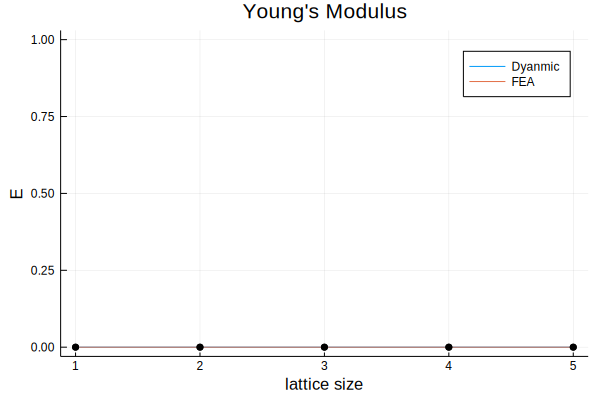

In [25]:
plot(1:5,Es,label="Dyanmic",xlabel="lattice size",ylabel="E",title="Young's Modulus")
plot!(1:5,EsFEA,label="FEA")
scatter!(1:5,Es,color="black",label="")
scatter!(1:5,EsFEA,color="black",label="")
# savefig("youngs_modulus")

In [26]:
plot()
for i in 1:5
    plot!(1:step:numTimeStepsRecorded,DDisplacements[i],label="Lattice size: $i",xlabel="timestep",ylabel="displacement",title="Dynamic Model Convergence")

end
plot!()
# savefig("dynamic_convergence")

UndefVarError: UndefVarError: numTimeStepsRecorded not defined